In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [6]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()

In [8]:
# filter data to make sure only ages from both dataset appear in subsequent analysis
mask = data.index.get_level_values('age').intersection(data_dana.index.get_level_values('age'))
fdata = data[data.index.get_level_values('age').isin(mask)]
fdata_dana = data_dana[data_dana.index.get_level_values('age').isin(mask)]

In [9]:
## PC COMPARISONS

In [10]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(np.log(fdata + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata.index.get_level_values('age')

[0.38864489 0.54515395]


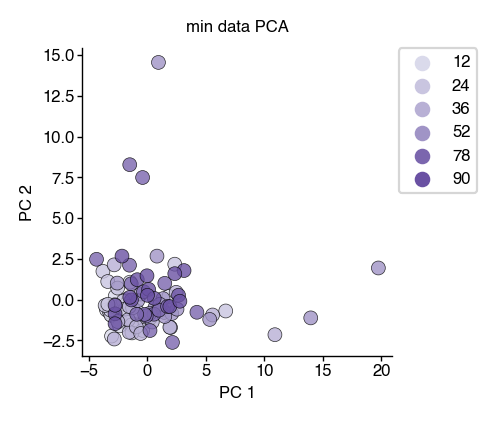

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
sns.scatterplot(data=pc_df, x=pc_df[0], y=pc_df[1], 
                hue="age",
                palette=cmm,
                legend="full",
                s=25,
                alpha=0.8,
                edgecolor='black',
                linewidth=0.25,
                ax=ax
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("min data PCA")
#plt.title("pca males")
sns.despine()

#norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
#sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm.set_array([])

# Remove the legend and add a colorbar
#ax.get_legend().remove()
#ax.figure.colorbar(sm)
plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


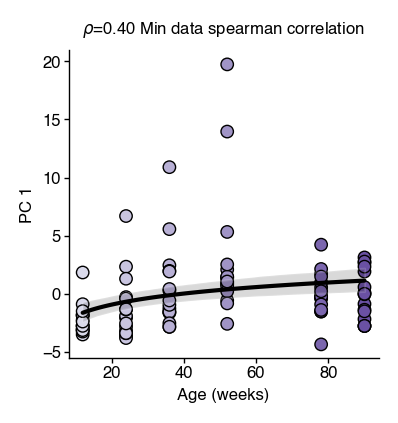

In [12]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], fdata.index.get_level_values('age'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
im = plt.scatter(x=pc_df['age'], y=pc_df[0], 
            s=20, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.5,
            #norm='log',
            cmap=cmm)
#cb=fig.colorbar(im,ax=ax)
plt.title(f'$\\rho$={c:0.2f} Min data spearman correlation')
ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=True)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
sns.despine()

In [13]:
n=10
pca = PCA(n_components=n)
pcs = pca.fit_transform(np.log(fdata + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata.index.get_level_values('age')

[0.38864489 0.54515395 0.64589255 0.72176518 0.77460185 0.8230456
 0.85218642 0.87043576 0.88741041 0.90194492]


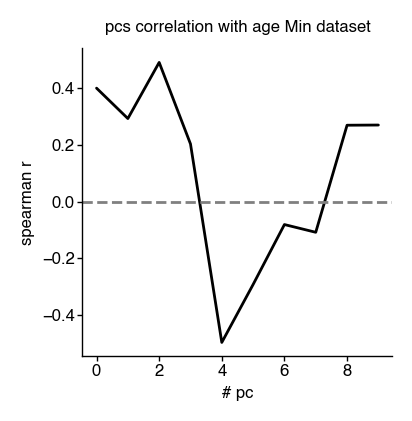

In [14]:
correlations = pc_df.loc[:,0:n-1].apply(lambda col: col.corr(pc_df['age'], method='spearman'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(correlations,c='black')
plt.title('pcs correlation with age Min dataset')
plt.xlabel('# pc')
plt.ylabel('spearman r')
sns.despine()
ax.axhline(y=0, color='gray', linestyle='--')

In [15]:
#pc dana data

In [16]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(np.log(fdata_dana + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata_dana.index.get_level_values('age')

[0.50118537 0.59632082]


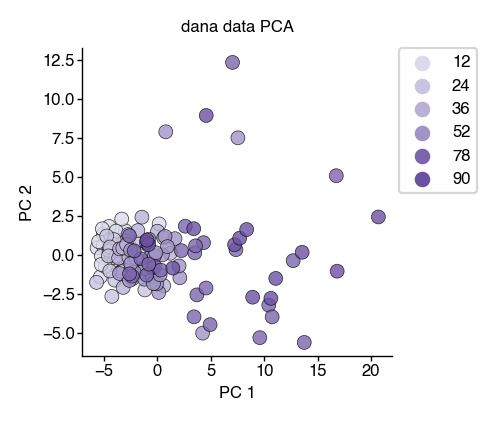

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
sns.scatterplot(data=pc_df, x=pc_df[0], y=pc_df[1], 
                hue="age",
                palette=cmm,
                legend="full",
                s=25,
                alpha=0.8,
                edgecolor='black',
                linewidth=0.25,
                ax=ax
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("dana data PCA")
#plt.title("pca males")
sns.despine()

#norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
#sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm.set_array([])

# Remove the legend and add a colorbar
#ax.get_legend().remove()
#ax.figure.colorbar(sm)
plt.show()

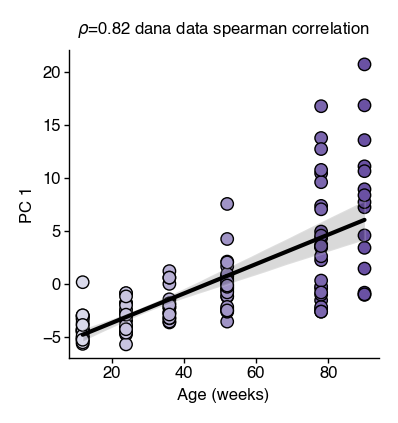

In [18]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], fdata_dana.index.get_level_values('age'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
im = plt.scatter(x=pc_df['age'], y=pc_df[0], 
            s=20, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.5,
            #norm='log',
            cmap=cmm)
#cb=fig.colorbar(im,ax=ax)
plt.title(f'$\\rho$={c:0.2f} dana data spearman correlation')
ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=False)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
sns.despine()

In [19]:
n=10
pca = PCA(n_components=n)
pcs = pca.fit_transform(np.log(fdata_dana + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata_dana.index.get_level_values('age')

[0.50118537 0.59632082 0.66759807 0.72114834 0.76093599 0.79610906
 0.82773392 0.85372143 0.87478864 0.89457318]


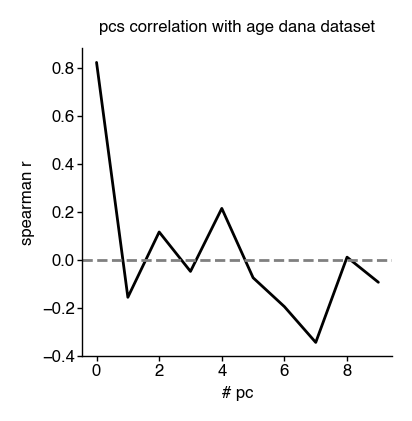

In [20]:
correlations = pc_df.loc[:,0:n-1].apply(lambda col: col.corr(pc_df['age'], method='spearman'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(correlations,c='black')
plt.title('pcs correlation with age dana dataset')
plt.xlabel('# pc')
plt.ylabel('spearman r')
sns.despine()
ax.axhline(y=0, color='gray', linestyle='--')

Text(0.5, 0, 'PC3')

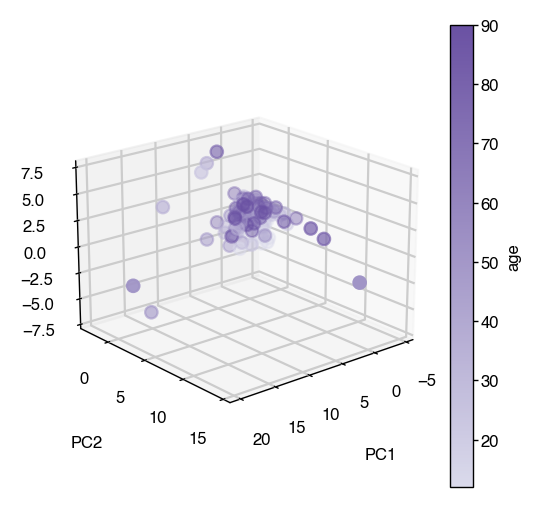

In [21]:
## 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

pcs3 = PCA(n_components=3).fit_transform(np.log(fdata + 1e-6))
ages = fdata.index.get_level_values('age')
pc3_df = pd.DataFrame(pcs3)
pc3_df['age'] = ages

# Create a 3D figure
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pc3_df[0], pc3_df[1], pc3_df[2], c=ages, cmap=cmm)

cbar = plt.colorbar(scatter)
cbar.set_label('age')

# Set custom viewing angles (elevation, azimuthal)
ax.view_init(elev=20, azim=50)

# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [22]:
## syllables over time

In [23]:
# for min's data
# arrange data
data_labels = fdata.index.get_level_values('age').to_numpy()
data = fdata.to_numpy()

In [24]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

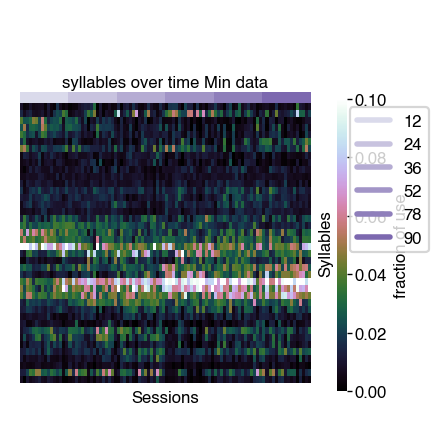

In [25]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=data.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=True,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.1)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('syllables over time Min data')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)

plt.show()

In [26]:
# for dana's data
# arrange data
data_labels = fdata_dana.index.get_level_values('age').to_numpy()
data = fdata_dana.to_numpy()

In [27]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

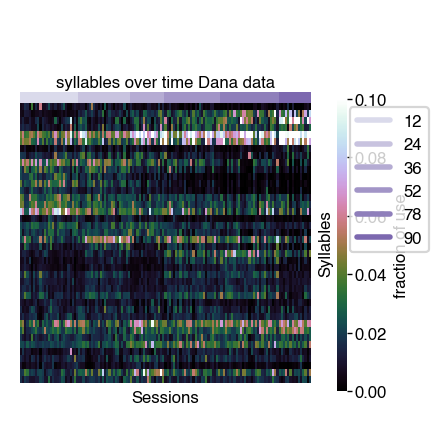

In [28]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=data.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=True,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.1)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('syllables over time Dana data')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)

plt.show()

In [29]:
## correlation matrix
from scipy.spatial.distance import pdist, squareform

In [30]:
# get JSD
kld = squareform(pdist(fdata, metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata.index.get_level_values('age').to_numpy()

In [31]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

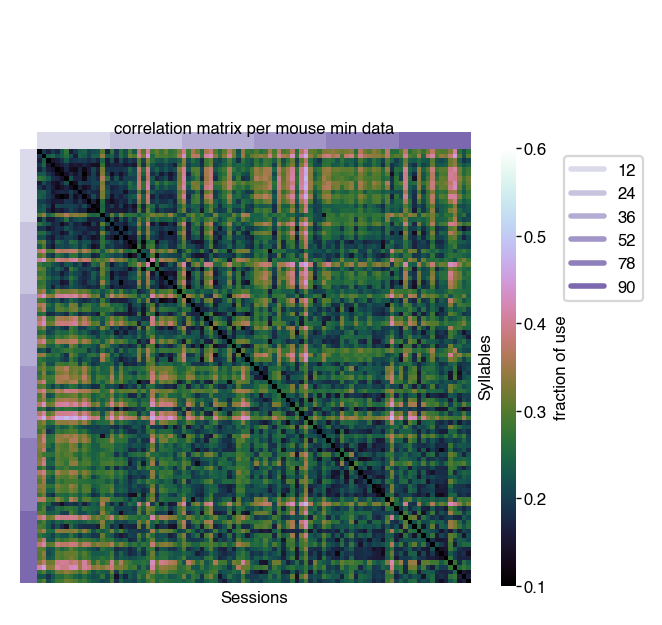

In [32]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    metric='sqeuclidean',
    #metric='cosine',
    rasterized=True,
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('correlation matrix per mouse min data')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [33]:
# get JSD
kld = squareform(pdist(fdata_dana, metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata_dana.index.get_level_values('age').to_numpy()

In [34]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

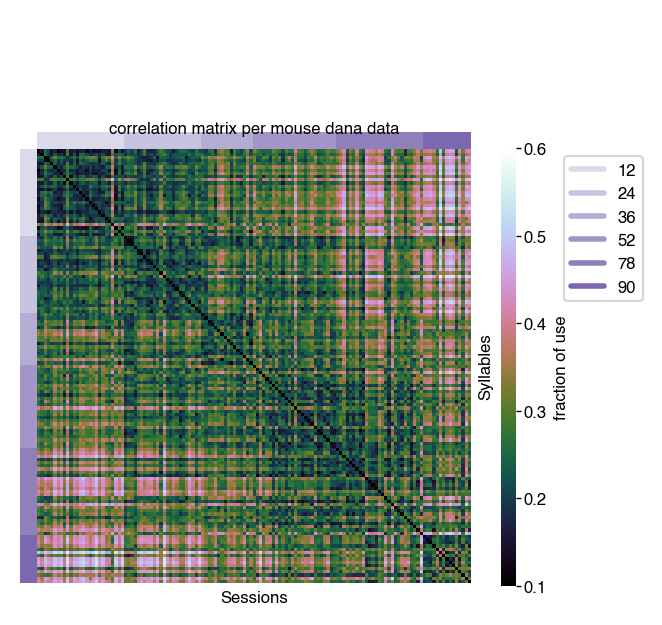

In [35]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    metric='sqeuclidean',
    #metric='cosine',
    rasterized=True,
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('correlation matrix per mouse dana data')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [51]:
## pca of both datasets

In [52]:
# use only common ages
fdata['sex'] = 'min'
fdata.set_index('sex',inplace=True,append=True)

fdata_dana['sex'] = 'dana'
fdata_dana.set_index('sex',inplace=True,append=True)

data=pd.concat([fdata_dana,fdata])

In [53]:
pc = PCA(n_components=2)
pc.fit(data)
pcs_male = pc.transform(fdata)
pcs_female = pc.transform(fdata_dana)

pcm = pd.DataFrame(pcs_male)
pcm['psd'] = fdata.index.get_level_values('age')

pcf = pd.DataFrame(pcs_female)
pcf['psd'] = fdata_dana.index.get_level_values('age')

In [54]:
variance_explained = pc.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [55]:
cumulative_variance_explained

array([0.41163981, 0.56095725])

Text(0.5, 1.0, 'pca fit on both')

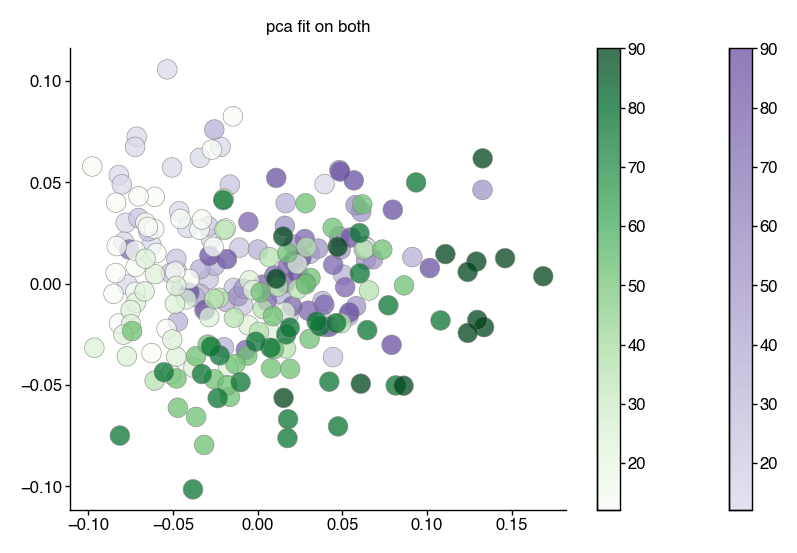

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='grey',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcf[0], y=pcf[1], 
                cmap='Greens',
                s=50,
                edgecolor='grey',
                c=pcf['psd'], 
                linewidth=0.25,
                #norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
sns.despine()
c = PlotConfig()
plt.title('pca fit on both')
#fig.savefig(c.dana_save_path / "fig4"/ 'fvm_pca_fit_on_both.pdf')

In [57]:
## decoder

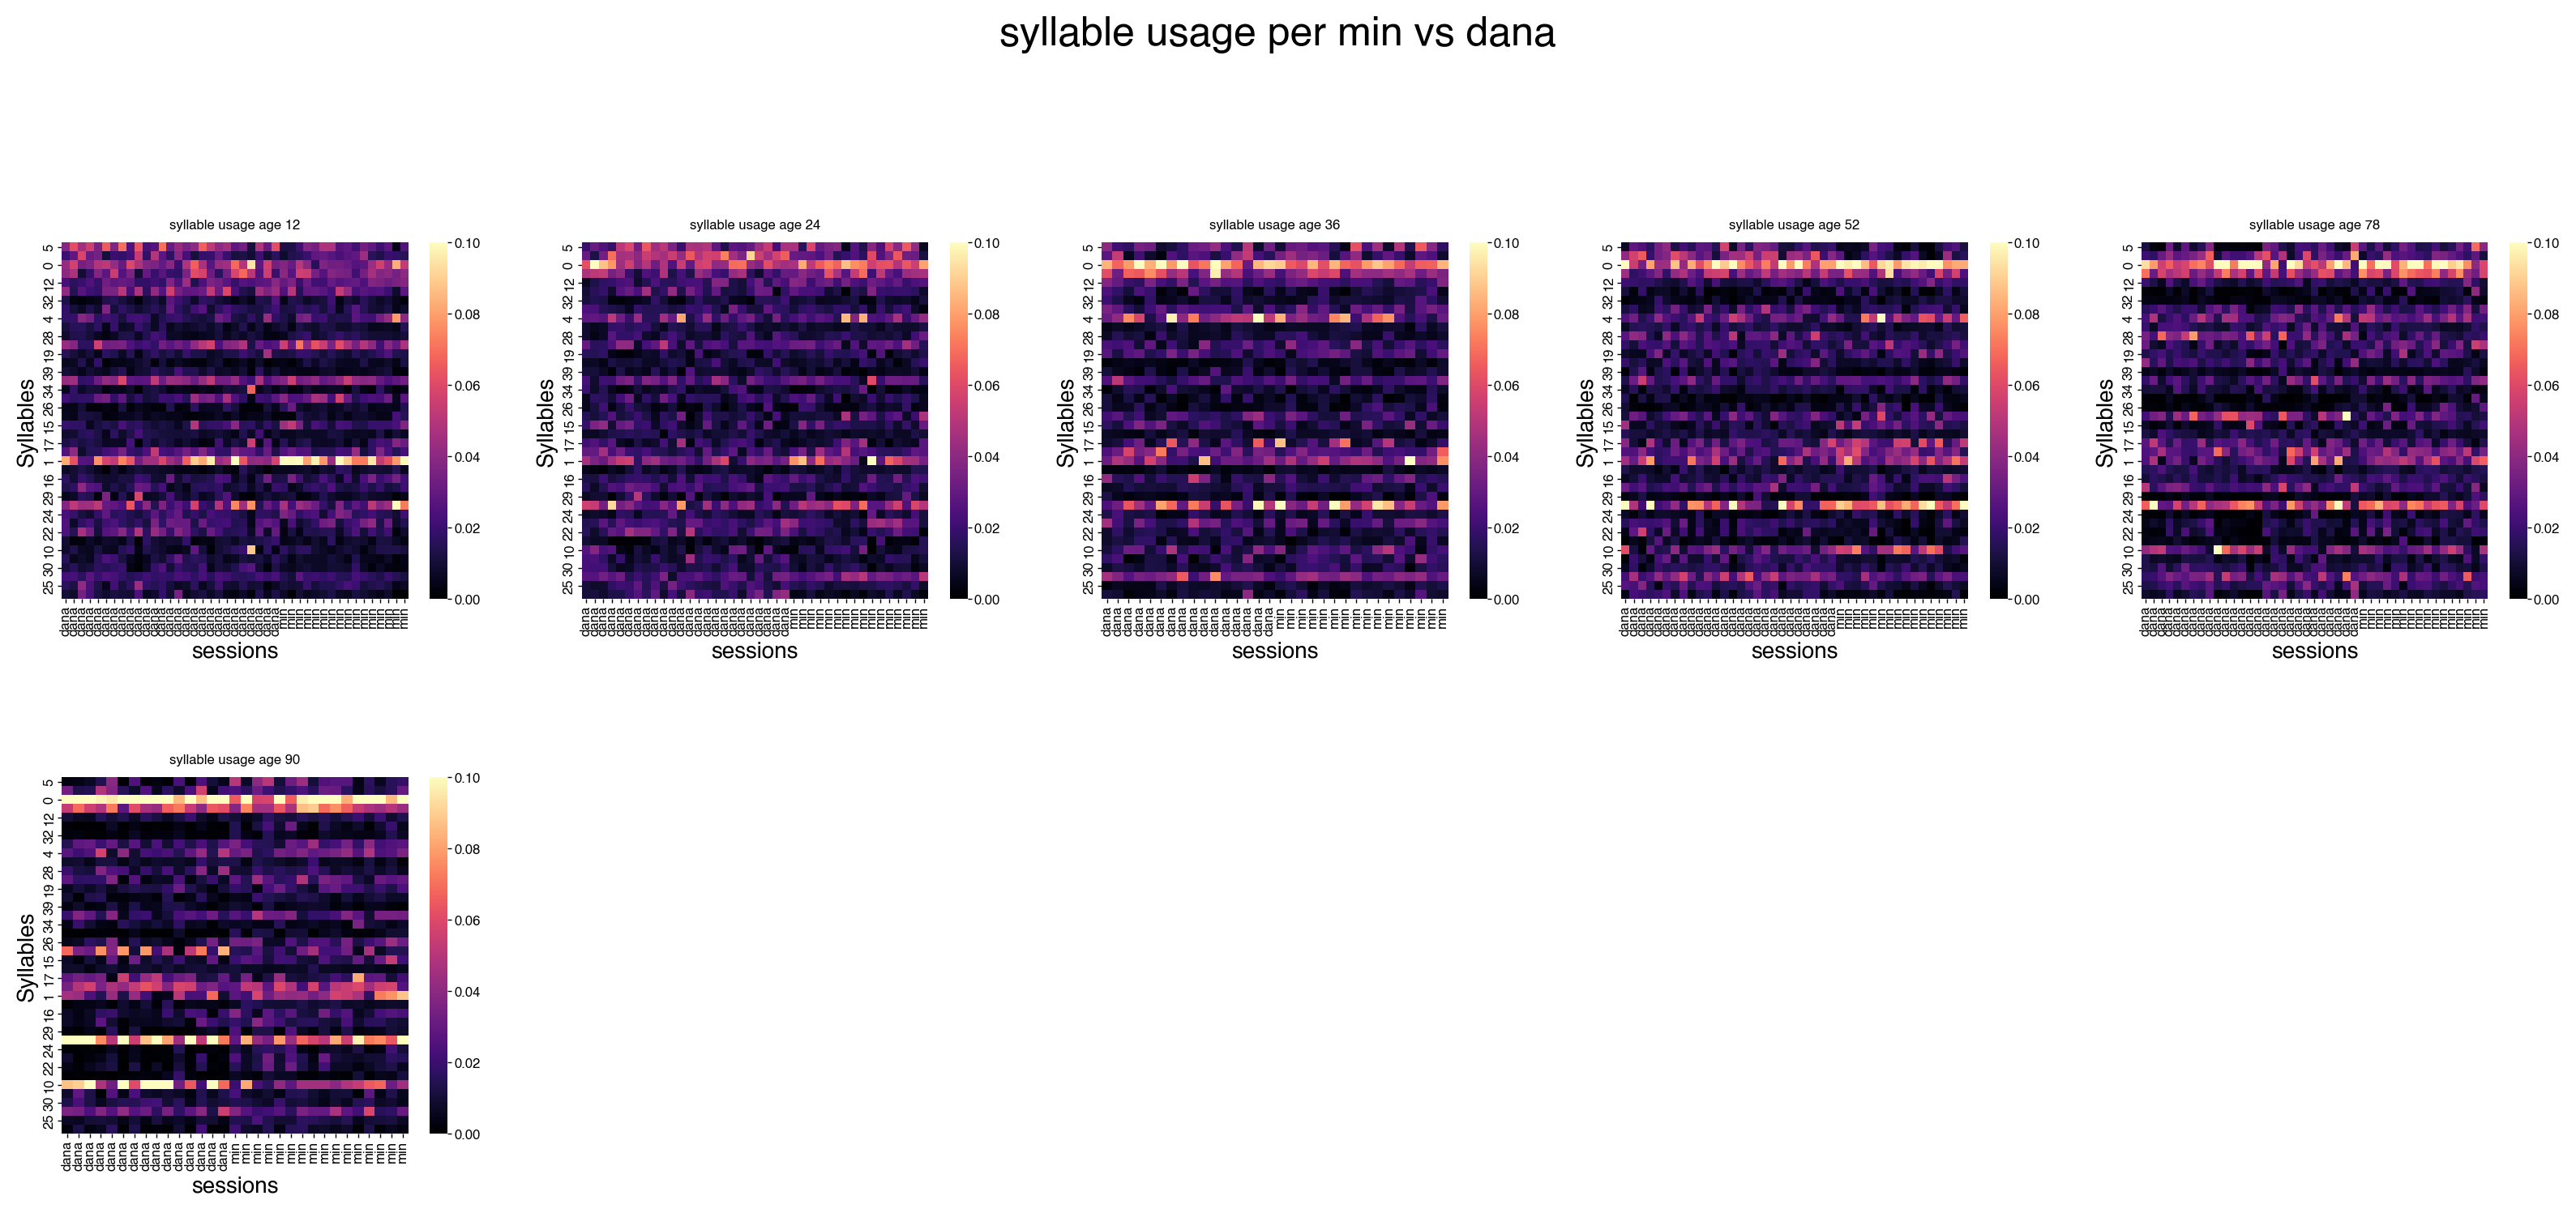

In [59]:
n=0
fig=plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("syllable usage per min vs dana", fontsize=18, y=0.95)
for age,_df in enumerate(data.groupby('age')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    x = _df[1]
    sex = _df[1].index.get_level_values('sex').to_numpy()
    ax = plt.subplot(5, 5, n + 1)
    sns.heatmap(x.T,cmap = 'magma',vmax=0.1, xticklabels= sex)
    ax.set_title('syllable usage age ' + str(_df[0]))
    ax.set_ylabel('Syllables',fontsize=10)
    ax.set_xlabel('sessions',fontsize=10)
    n=n+1